### Fine Tip Clearance Test Objective


### Procedure
- Ensure the drone is positioned on the tester rails such that the fishing line is slack
- Fix the current limit of the DC power supply connected in parallel with the lead acid battery to the same value for all tests. This should be a value between 2 and 8 amps, since the supply is fused at 10A
- Initiate sweep from 30-100% throttle in increments of 10%, holding each throttle for 10 seconds.
- At each throttle step, allow ~2s for transient behaviour to settle and then average over the remaining data (~250 samples) to produce a single DC measurement for thrust, power, rpm, etc. at each point in the sweep.
- Repeat experiment at least once for each aerodynamic configuration, disassembling and reassembling between tests to ensure repeatability.

### Coarse Tip Clearance Test Configurations
| Static Tip Clearance | Clearance to Height Ratio (%) |
|-                     |-                              |
| 1.0 mm               | 14.3 %                        |
| 0.9 mm               | 12.9 %                        |
| 0.8 mm               | 11.4 %                        |
| 0.7 mm               | 10.0 %                        |
| 0.6 mm               | 8.57 %                        |
| 0.5 mm               | 7.14 %                        |
| 0.4 mm               | 5.71 %                        |
| 0.3 mm               | 4.29 %                        |
| 0.2 mm               | 2.86 %                        |
| 0.1 mm               | 1.43 %                        |

### Hypothesis
- As tip clearance decreases, we expect thrust to electrical power efficiency (kgf/W) to increase.

In [2]:
from runner import test_run, TestPlan, TestStep
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Specify Test Plan
Initialize a test plan object which sweeps from 30 to 100% throttle in increments of 10%, holding at each step for 10 seconds

In [3]:
# 1. Create a test plan consisting of steps.
step_duration_ms = 10_000
step_range = np.arange(30, 101, 10)

steps = [
    TestStep(bottom_throttle=i, top_throttle=i, duration_ms=step_duration_ms)
    for i in step_range
]
plan = TestPlan("test", steps=steps)

plan

TestPlan(name='test', steps=[TestStep(duration_ms=10000, top_throttle=30, bottom_throttle=30, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=40, bottom_throttle=40, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=50, bottom_throttle=50, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=60, bottom_throttle=60, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=70, bottom_throttle=70, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=80, bottom_throttle=80, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=90, bottom_throttle=90, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=100, bottom_throttle=100, pitch_angle=None, roll_angle=None)])

In [4]:
print(plan)

TestPlan(name='test', steps=[TestStep(duration_ms=10000, top_throttle=30, bottom_throttle=30, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=40, bottom_throttle=40, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=50, bottom_throttle=50, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=60, bottom_throttle=60, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=70, bottom_throttle=70, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=80, bottom_throttle=80, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=90, bottom_throttle=90, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=100, bottom_throttle=100, pitch_angle=None, roll_angle=None)])


### Execute Tests

In [5]:
# Initialize short thrust test to validate propeller mounting direction after changing props
test_duration_ms = 2000
mount_test_throttle = 10
perform_mounting_test = True

mount_test_plan = TestPlan("test", steps=[TestStep(bottom_throttle=mount_test_throttle, top_throttle=mount_test_throttle, duration_ms=test_duration_ms)])

In [6]:
### Execute optional mounting test
if (perform_mounting_test):
    try:
        test_run(filename=None, plan=mount_test_plan)
    except Exception as e:
        print(e)

could not open port 'COM9': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)


In [7]:
test_directory = Path("../test_data/fine_tip_clearance_revised/")

In [8]:
data_dict = {}
files = [
    # # 0.3
    "test_0.3mm_pb_0.csv",
    "test_0.3mm_pb_1.csv",
    "test_0.3mm_pb_2.csv",

    # # # 0.4
    "test_0.4mm_pb_0.csv",
    "test_0.4mm_pb_1.csv",
    "test_0.4mm_pb_2.csv",
    "test_0.4mm_pb_3.csv",

    # # # 0.5
    "test_0.5mm_pb_0.csv",
    "test_0.5mm_pb_1.csv",
    "test_0.5mm_pb_2.csv",
    "test_0.5mm_pb_3.csv",

    # # # 0.6
    "test_0.6mm_pb_0.csv",
    "test_0.6mm_pb_1.csv",
    "test_0.6mm_pb_2.csv",
    "test_0.6mm_pb_3.csv",

    # # # 0.7
    "test_0.7mm_pb_0.csv",
    "test_0.7mm_pb_1.csv",
    "test_0.7mm_pb_2.csv",
    "test_0.7mm_pb_3.csv",

    # # # 0.8
    "test_0.8mm_pb_0.csv",
    "test_0.8mm_pb_1.csv",
    "test_0.8mm_pb_2.csv",
    "test_0.8mm_pb_3.csv",

    # # # 0.9
    "test_0.9mm_pb_0.csv",
    "test_0.9mm_pb_2.csv",
    "test_0.9mm_pb_3.csv",

    # # 1
    "test_1mm_pb_0.csv",
    "test_1mm_pb_1.csv",
    "test_1mm_pb_2.csv",
    "test_1mm_pb_3.csv",

    # # Open air
    "test_0mm_pb_0.csv",
    "test_0mm_pb_1.csv",
    "test_0mm_pb_2.csv",
    "test_0mm_pb_3.csv",

    # Open air
    # "test_single_top_pb_0.csv",
    # "test_single_top_pb_1.csv",
    # "test_single_top_pb_4.csv",
    # "test_single_top_pb_5.csv",

    # "test_single_bottom_pb_0.csv",
    # "test_single_bottom_pb_1.csv",
    # "test_single_bottom_pb_3.csv",
]

for file in files:
    data_dict[file] = test_run(
        filename=test_directory / file, plan=plan
    )

Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data
Loading saved data


### Data Analysis

In [9]:
# Aggregate test data
tip_filename_regex = re.compile(r"test_(\d*\.?\d*)mm")


df_all = pd.concat(
    data_dict.values(),
    keys=[
        (
            file,
            (
                float(match.group(1))
                if (match := tip_filename_regex.match(file))
                else 'N/A'
            ),
        )
        for file in files
    ],
    names=["test_name", "tip_clearance_mm"],
).sort_index()
df_all

top_motor_rpm  \
test_name           tip_clearance_mm time_ms                    
test_0.3mm_pb_0.csv 0.3              0.481                0.0   
                                     5.162                0.0   
                                     9.169                0.0   
                                     13.157               0.0   
                                     17.165               0.0   
...                                                       ...   
test_1mm_pb_3.csv   1.0              81965.157         1200.0   
                                     81969.161         1171.0   
                                     81973.157         1128.0   
                                     81977.157         1100.0   
                                     81981.151         1057.0   

                                                bottom_motor_rpm  \
test_name           tip_clearance_mm time_ms                       
test_0.3mm_pb_0.csv 0.3              0.481                   0.0   
                                     5.162                   0.0   
                                     9.169                   0.0   
                                     13.157                  0.0   
                                     17.165                  0.0   
...                                                          ...   
test_1mm_pb_3.csv   1.0              81965.157            1271.0   
                                     81969.161            1228.0   
                                     81973.157            1142.0   
                                     81977.157            1157.0   
                                     81981.151            1071.0   

                                                batt_voltage_V  \
test_name           tip_clearance_mm time_ms                     
test_0.3mm_pb_0.csv 0.3              0.481              15.204   
                                     5.162              14.385   
                                     9.169              14.112   
                                     13.157             14.028   
                                     17.165             14.028   
...                                                        ...   
test_1mm_pb_3.csv   1.0              81965.157          12.726   
                                     81969.161          12.705   
                                     81973.157          12.747   
                                     81977.157          12.705   
                                     81981.151          12.726   

                                                batt_current_A  top_current_A  \
test_name           tip_clearance_mm time_ms                                    
test_0.3mm_pb_0.csv 0.3              0.481               10.24        0.20356   
                                     5.162               10.24        0.05816   
                                     9.169               10.24        0.24718   
                                     13.157              10.24        0.20356   
                                     17.165              10.24        0.24718   
...                                                        ...            ...   
test_1mm_pb_3.csv   1.0              81965.157           10.24        0.07270   
                                     81969.161           10.24       -0.11632   
                                     81973.157           10.24        0.34896   
                                     81977.157           10.24        0.13086   
                                     81981.151           10.24        0.11632   

                                                bottom_current_A  thrust_N  \
test_name           tip_clearance_mm time_ms                                 
test_0.3mm_pb_0.csv 0.3              0.481              -0.12519  0.508665   
                                     5.162              -0.20865  0.508665   
                                     9.169              -0.13910  0.508665   
              

In [10]:
# Generate buckets for averaging based on step duration defined in testing
transient_offset_ms = (
    2000  # Ignore first 500 ms of each throttle step to allow transients to settle
)
stable_step_duration_ms = step_duration_ms - transient_offset_ms
step_start_times = np.arange(len(step_range)) * step_duration_ms


# Aggregate data for each throttle step
df_steps = (
    pd.concat(
        [
            df_all.loc[
                (
                    slice(None),
                    slice(None),
                    slice(
                        t_start + transient_offset_ms,
                        t_start + transient_offset_ms + stable_step_duration_ms,
                    ),
                ),
                :,
            ]
            for t_start in step_start_times
        ],
        keys=step_range,
        names=["throttle"],
    )
    .groupby(["test_name", "tip_clearance_mm", "throttle"])
    .agg(["mean", "std"])
)

df_steps

top_motor_rpm              \
                                                       mean         std   
test_name           tip_clearance_mm throttle                             
test_0.3mm_pb_0.csv 0.3              30         6768.615000   48.676920   
                                     40         8633.708253   89.058746   
                                     50         9771.128500  116.843186   
                                     60        11199.204635  303.260269   
                                     70        12306.132000  104.911443   
...                                                     ...         ...   
test_1mm_pb_3.csv   1.0              60        11417.585500   94.715037   
                                     70        12623.523500  105.071883   
                                     80        13780.427000  329.895217   
                                     90        14888.892500   87.540594   
                                     100       15799.270500   68.004983   

                                              bottom_motor_rpm              \
                                                          mean         std   
test_name           tip_clearance_mm throttle                                
test_0.3mm_pb_0.csv 0.3              30             6639.91600   47.385036   
                                     40             8365.93858   88.898308   
                                     50             9491.74450  117.918899   
                                     60            10836.83437  149.672479   
                                     70            11921.80900  103.071259   
...                                                        ...         ...   
test_1mm_pb_3.csv   1.0              60            10979.27300  161.915443   
                                     70            12080.78150   99.032639   
                                     80            13164.69850  116.042796   
                                     90            14214.41600  336.066541   
                                     100           15058.10700  118.404850   

                                              batt_voltage_V            \
                                                        mean       std   
test_name           tip_clearance_mm throttle                            
test_0.3mm_pb_0.csv 0.3              30            13.757751  0.010266   
                                     40            13.638123  0.023343   
                                     50            12.848976  0.030507   
                                     60            12.473430  0.046441   
                                     70            12.059208  0.020076   
...                                                      ...       ...   
test_1mm_pb_3.csv   1.0              60            12.620433  0.021362   
                                     70            12.202953  0.050357   
                                     80            11.766059  0.065408   
                                     90            11.454429  0.025087   
                                     100           11.075211  0.032016   

                                              batt_current_A            \
                                                        mean       std   
test_name           tip_clearance_mm throttle                            
test_0.3mm_pb_0.csv 0.3              30            10.240000  0.000000   
                                     40            10.240205  0.008094   
                                     50            10.382840  0.349024   
                                     60            14.047937  1.021476   
                                     70            18.847400  1.014304   
...                                                      ...       ...   
test_1mm_pb_3.csv   1.0              60            13.838720  0.995021   
                                     70            18.610480  1.089556   
                                     80            

In [11]:
# Debug plots
# fig = plt.figure(figsize=(12, 6*len(data_dict)))
# subfigs = fig.subfigures(len(data_dict), 1)
# if not isinstance(subfigs, np.ndarray):
#     subfigs = np.array([subfigs])
# for subfig, (n, grp) in zip(subfigs, df_all.groupby("test_name")):
#     axs = subfig.subplots(2, 4)
#     for ax, col in zip(axs.flat, grp):
#         grp.reset_index(("test_name", "tip_clearance_mm")).plot(ax=ax, y=col)
#         ax.hlines(
#             df_steps[col].loc[n]["mean"],
#             step_start_times + transient_offset_ms,
#             step_start_times + transient_offset_ms + stable_step_duration_ms,
#             colors="C1",
#             label="Averages",
#         )
#         ax.legend()
#     subfig.suptitle(n)

In [12]:
thrust_mean_g = df_steps["thrust_N"]["mean"] / 9.81 * 1e3
thrust_g_err = df_steps["thrust_N"]["std"] / 9.81 * 1e3

hall_current_mean = df_steps["top_current_A"]["mean"] + df_steps["bottom_current_A"]["mean"]
hall_current_rel_err = (0.02294 * hall_current_mean + 0.3734) / hall_current_mean

batt_voltage_mean = df_steps["batt_voltage_V"]["mean"]
batt_voltage_rel_err = df_steps["batt_voltage_V"]["std"] / batt_voltage_mean

shunt_current_mean = df_steps["batt_current_A"]["mean"]
shunt_power_mean = shunt_current_mean * batt_voltage_mean

batt_power_mean = hall_current_mean * batt_voltage_mean
batt_power_rel_err = np.sqrt(hall_current_rel_err**2 + batt_voltage_rel_err**2)

thrust_power_rel_err = np.sqrt((thrust_g_err / thrust_mean_g)**2 + batt_power_rel_err**2)
thrust_mean_g = thrust_mean_g * (thrust_mean_g > 0)

rpm_avg = 0.5*(df_steps["top_motor_rpm"]["mean"] + df_steps["bottom_motor_rpm"]["mean"])

df_thrust_power = pd.DataFrame(
    {
        "rpm_avg": rpm_avg,
        "thrust_mean_g": thrust_mean_g,
        "batt_power_mean": batt_power_mean,
        "batt_voltage_mean": batt_voltage_mean,
        "hall_current_mean": hall_current_mean,
        "shunt_power_mean": shunt_power_mean,
        "thrust_power_g_W": thrust_mean_g / batt_power_mean,
        "shunt_thrust_power_g_W": thrust_mean_g / shunt_power_mean,
        "batt_power_err": np.abs(batt_power_rel_err * batt_power_mean),
        "thrust_g_err": thrust_g_err,
        "thrust_power_err": thrust_power_rel_err * (thrust_mean_g / batt_power_mean)
    }
)

In [34]:
df_thrust_power_agg = df_thrust_power[(df_thrust_power.index.get_level_values('throttle') >= 60)].groupby('tip_clearance_mm').agg('mean')

tip_clearance_mm = df_thrust_power_agg.index.get_level_values('tip_clearance_mm')[1:].to_numpy()
thrust_power_ratio = df_thrust_power_agg['thrust_power_g_W'].to_numpy()[1:]
tip_clearance_fit = np.polyfit(tip_clearance_mm, thrust_power_ratio, 1)
open_air_efficiency = df_thrust_power_agg.loc[0.0]['thrust_power_g_W']

# pct_efficiency_improvement = 100 * (np.max(thrust_power_ratio) / open_air_efficiency - 1.0)
# pct_efficiency_improvement

df_thrust_power_agg

open_air_efficiency

3.402665555886048

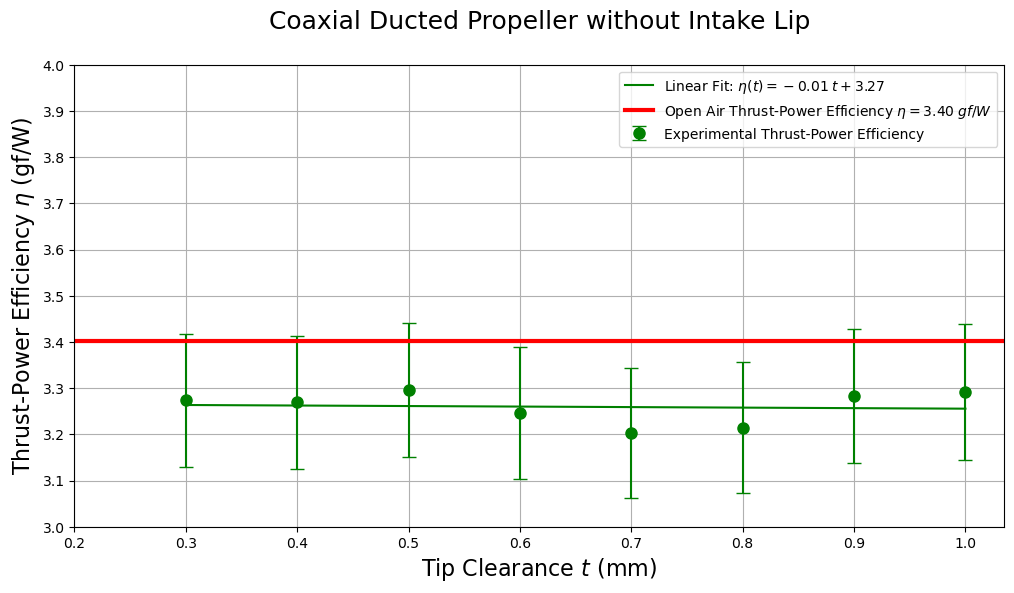

In [39]:
plt.figure(figsize=(12,6))

plt.errorbar(x = tip_clearance_mm, 
             y = thrust_power_ratio, 
             yerr = df_thrust_power_agg['thrust_power_err'].to_numpy()[1:],
             fmt='o', capsize=5, markersize=8, color='g', label='Experimental Thrust-Power Efficiency')
plt.plot(tip_clearance_mm, tip_clearance_fit[0]*tip_clearance_mm + tip_clearance_fit[1], label='Linear Fit: $\\eta(t) = {:.2f}\;t + {:.2f}$'.format(tip_clearance_fit[0], tip_clearance_fit[1]), color='g')
plt.axhline(open_air_efficiency, label='Open Air Thrust-Power Efficiency $\\eta = {:.2f}\;gf/W$'.format(open_air_efficiency), linewidth=3, color='r')
plt.xlabel('Tip Clearance $t$ (mm)', fontsize=16)
plt.ylabel('Thrust-Power Efficiency $\\eta$ (gf/W)', fontsize=16)
plt.title('Coaxial Ducted Propeller without Intake Lip\n', fontsize=18)
plt.yticks(np.arange(3, 4.01, 0.1))
plt.xticks(np.arange(0.2, 1.01, 0.1))
plt.legend()
plt.grid()

In [19]:
# Set nominal required thrust constants. Used as a benchmark to define region of interest for our data.
hover_thrust_g = 750
payload_thrust_g = 1200

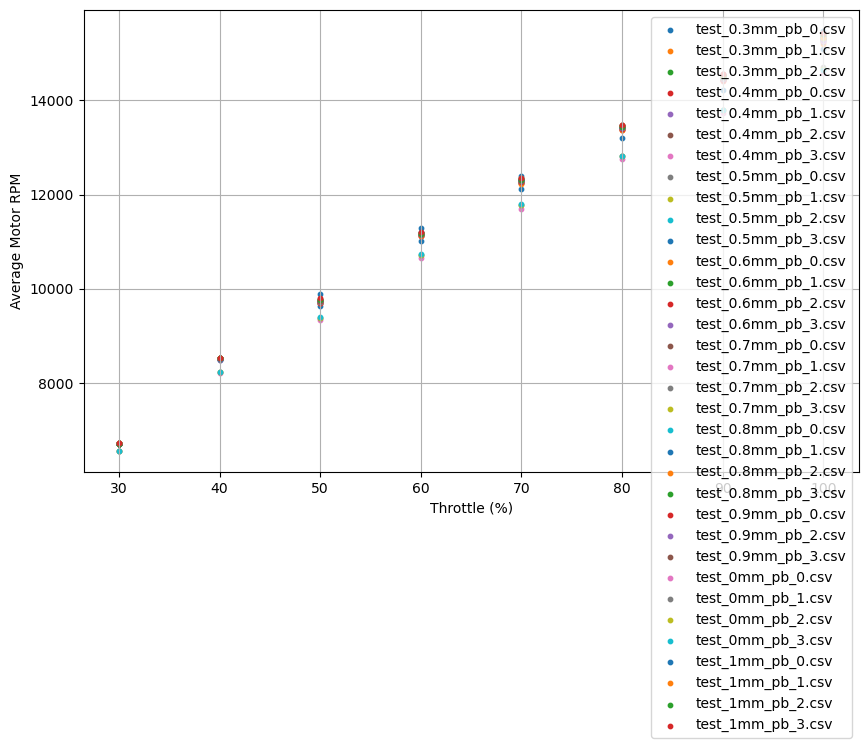

In [20]:
plt.figure(figsize=(10, 6))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x=grp.index.get_level_values("throttle"), y="rpm_avg", data=grp, label=n, s=10)
plt.xlabel("Throttle (%)")
plt.ylabel("Average Motor RPM")
plt.legend()
plt.grid()
plt.show()

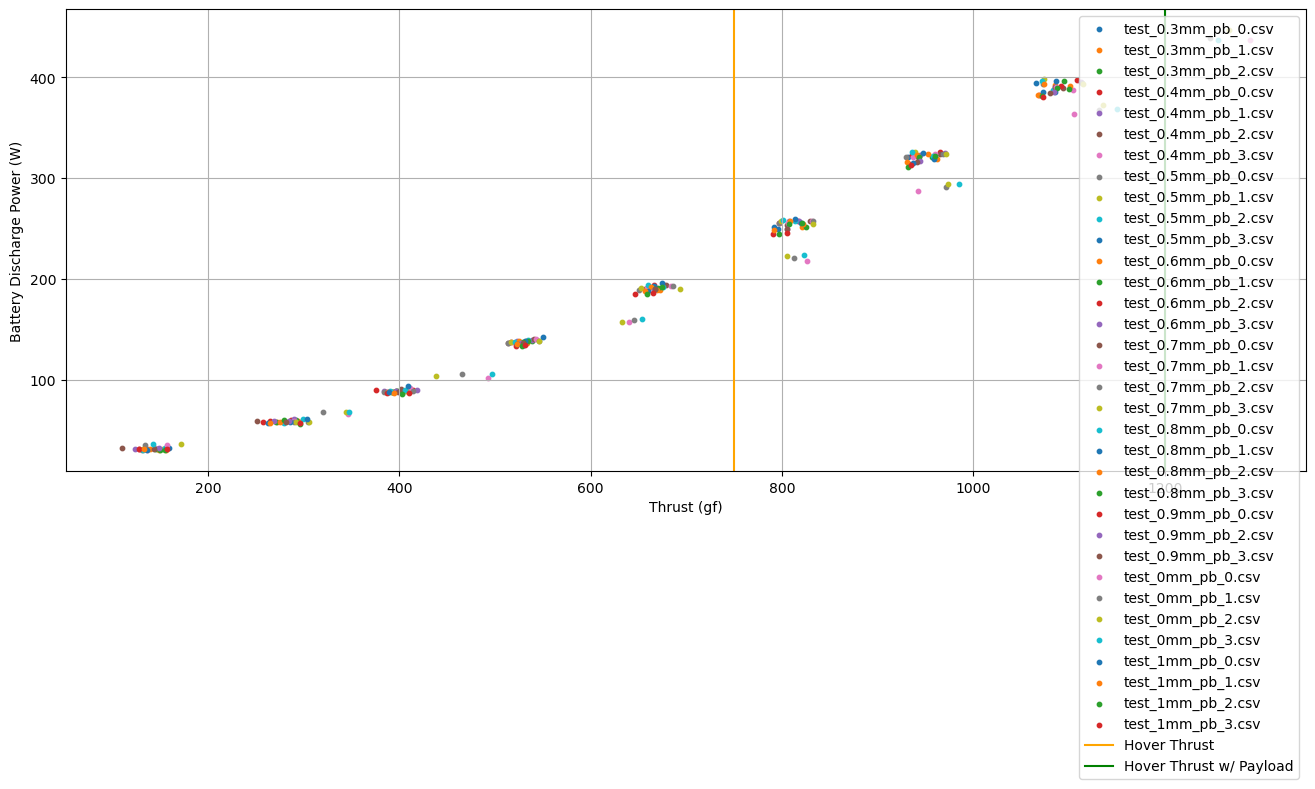

In [21]:
plt.figure(figsize=(16, 6))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x="thrust_mean_g", y="batt_power_mean", data=grp, label=n, s=10)
plt.xlabel("Thrust (gf)")
plt.ylabel("Battery Discharge Power (W)")
plt.grid()
plt.axvline(hover_thrust_g, color="orange", label="Hover Thrust")
plt.axvline(payload_thrust_g, color="g", label="Hover Thrust w/ Payload")
plt.legend()
plt.show()

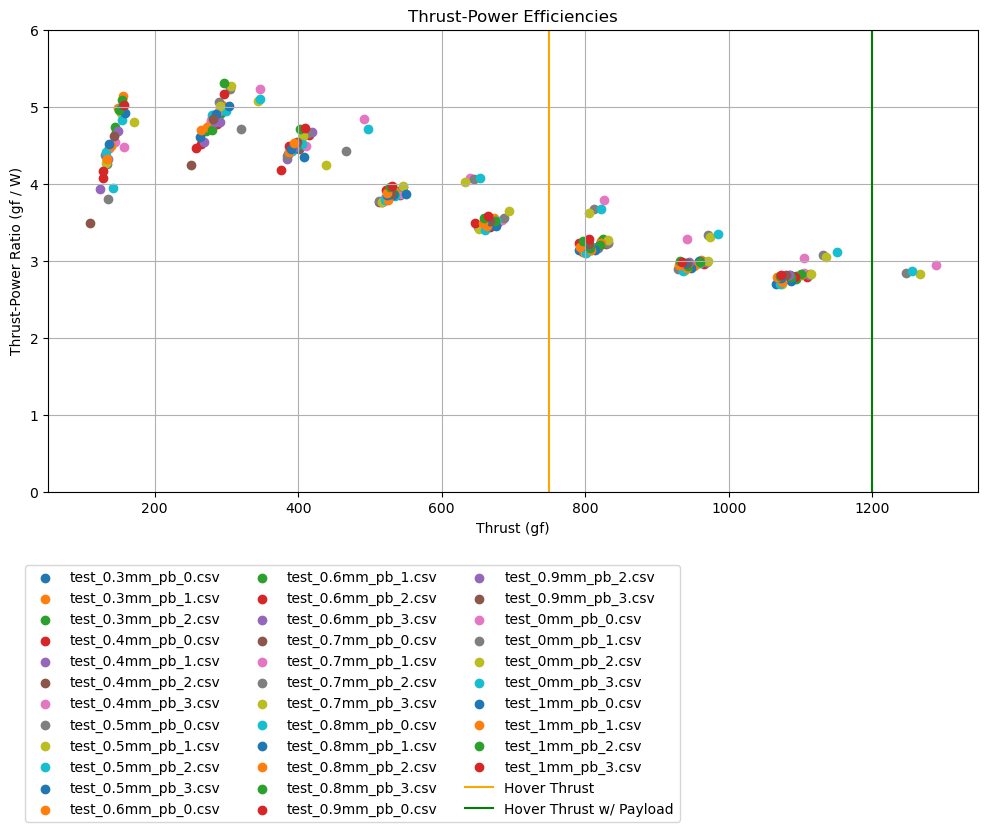

In [22]:
fig = plt.figure(figsize=(12, 6))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x="thrust_mean_g", y="thrust_power_g_W", data=grp, label=n)
plt.xlabel("Thrust (gf)")
plt.ylabel("Thrust-Power Ratio (gf / W)")
# plt.xlim(400, 1750)
plt.ylim(0,6)
plt.axvline(hover_thrust_g, color="orange", label="Hover Thrust")
plt.axvline(payload_thrust_g, color="g", label="Hover Thrust w/ Payload")
plt.grid()
plt.legend(ncols=3, bbox_transform=fig.transFigure, bbox_to_anchor=(0.1, 0), loc="upper left")
plt.title("Thrust-Power Efficiencies")
plt.show()

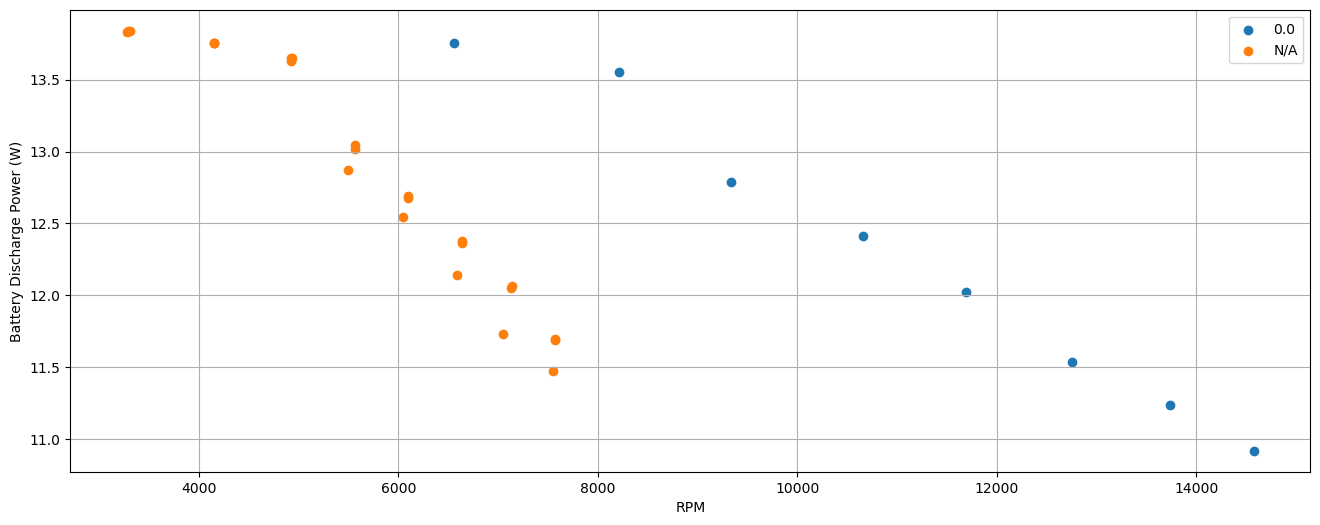

In [19]:
plt.figure(figsize=(16, 6))
for n, grp in df_thrust_power.groupby("tip_clearance_mm"):
    plt.scatter(x="rpm_avg", y="batt_voltage_mean", label=n, data=grp)
plt.xlabel("RPM")
plt.ylabel("Battery Discharge Power (W)")
plt.grid()
plt.legend()
plt.show()

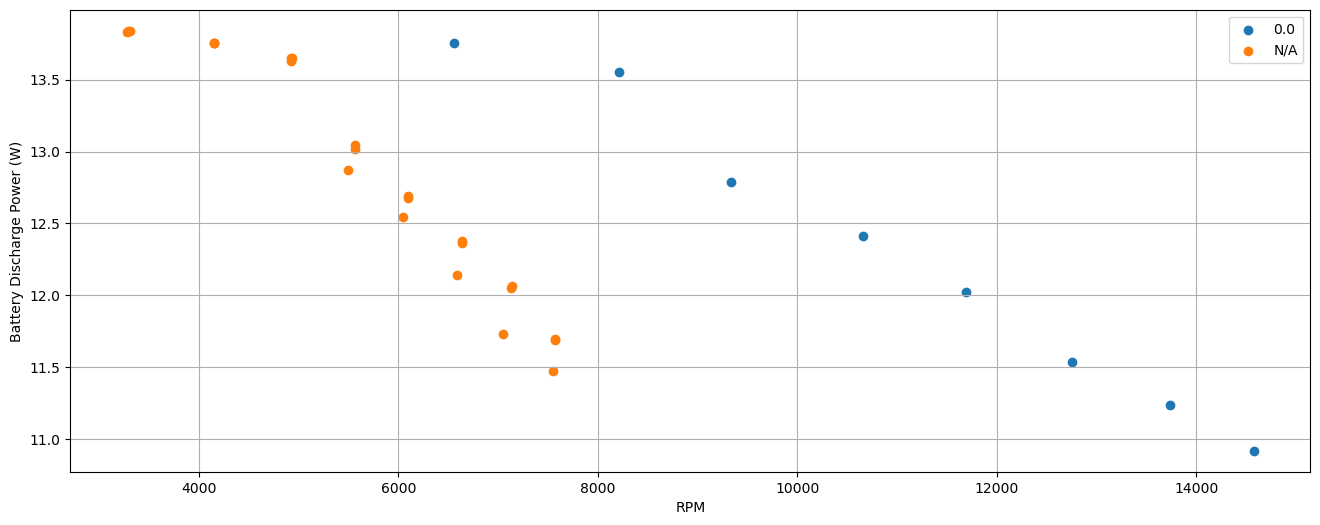

In [20]:
plt.figure(figsize=(16, 6))
for n, grp in df_thrust_power.groupby("tip_clearance_mm"):
    plt.scatter(x="rpm_avg", y="batt_voltage_mean", label=n, data=grp)
plt.xlabel("RPM")
plt.ylabel("Battery Discharge Power (W)")
plt.grid()
plt.legend()
plt.show()

# My Stuff

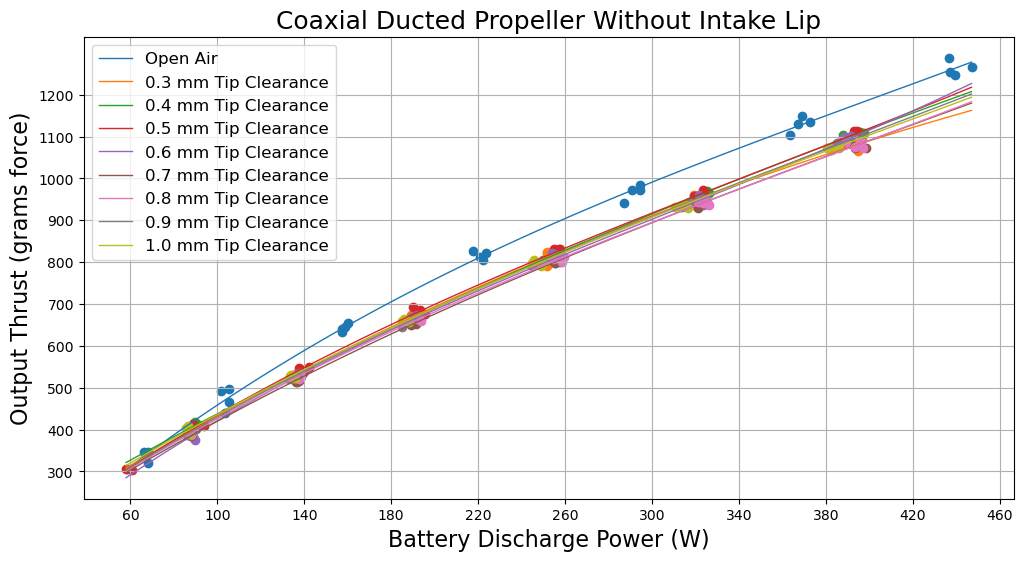

In [52]:
import numpy as np

DEGREE = 3
N = 100
min_thrust = 300
max_thrust = payload_thrust_g

x_label = "batt_power_mean"
y_label = "thrust_mean_g"
err_label = "batt_power_err"
x_min = 1e9
x_max = -1e9


def extract_roi(grp, x_label, ylabel, min_thrust, max_thrust):
    grp = grp[grp["thrust_mean_g"] > min_thrust]
    grp = grp.sort_values("thrust_mean_g")
    x = grp[x_label].to_numpy()
    y = grp[y_label].to_numpy()
    err = grp[err_label].to_numpy()
    return x, y, err


plt.figure(figsize=(12, 6))

# Analyze data.
for n, grp in df_thrust_power.groupby("tip_clearance_mm"):
    x, y, err = extract_roi(grp, x_label, y_label, min_thrust, max_thrust)
    x_min = min(x_min, min(x))
    x_max = max(x_max, max(x))

x_dense = np.linspace(x_min, x_max, N)

# Plot inerpolation.
for n, grp in df_thrust_power.groupby("tip_clearance_mm"):
    x, y, err = extract_roi(grp, x_label, y_label, min_thrust, max_thrust)
    coeffs = np.polyfit(x, y, DEGREE)
    poly = np.poly1d(coeffs)
    legend_label = str(n) + " mm Tip Clearance"
    if (n == 0.0): legend_label = "Open Air"

    plt.plot(x_dense, poly(x_dense), label=legend_label, linewidth=1)
    plt.scatter(x, y)

plt.xlabel("Battery Discharge Power (W)", fontsize=16)
plt.ylabel("Output Thrust (grams force)", fontsize=16)
plt.title('Coaxial Ducted Propeller Without Intake Lip', fontsize=18)
plt.grid()
plt.legend(fontsize=12)
plt.xticks(np.arange(60, 461, 40))
plt.yticks(np.arange(300, 1201, 100))
plt.show()

In [340]:
760/690

1.1014492753623188